In [29]:
# https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/
#  We will be using an item-based collaborative filtering algorithm for our purpose.


#getting the data up and running
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
movies = pd.read_csv("/content/drive/MyDrive/recomendation engine/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/recomendation engine/user_ratings.csv")
print(movies.head())
print(ratings.head())


final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')

print(final_dataset.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]
   userId  ...                                       genres
0       1  ...  Adventure|Animation|Children|Comedy|Fantasy
1       5  ...  Adventure|Animation|Children|Comedy|Fantasy
2       7  ...  Adventure|Animation|Children|Comedy|Fantasy
3      15  ...  Adventure|Animation|Children|Comedy|Fantasy
4      17  ...  Adventure|Animation|Children|Comedy|Fantasy

[5 rows x 6 columns]
userId   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
movieId                                     ...                                   
1        4.0  NaN  NaN  NaN  4.0  NaN  4.5  ...  3.0  4.0  2.5  

In [30]:
final_dataset.fillna(0,inplace=True)
print(final_dataset.head())

userId   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
movieId                                     ...                                   
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  ...  3.0  4.0  2.5  4.0  2.5  3.0  5.0
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  5.0  3.5  0.0  0.0  2.0  0.0  0.0
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  2.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  3.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 610 columns]


In [31]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

print(no_user_voted, no_movies_voted)

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64 userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


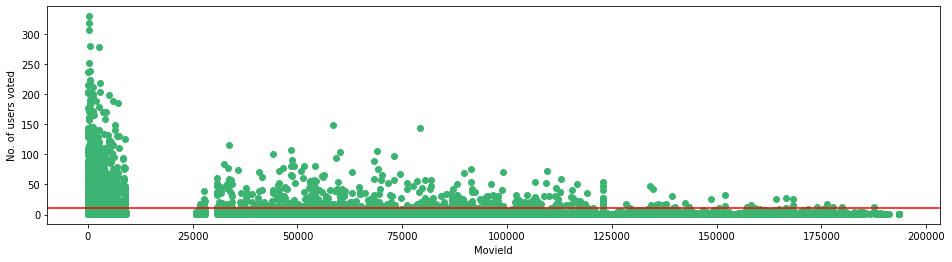

In [32]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [33]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

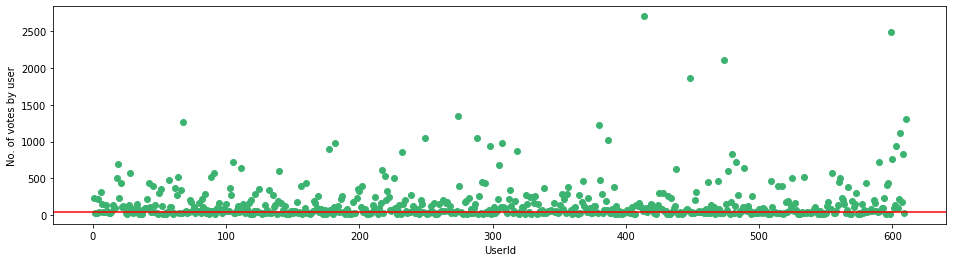

In [34]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [35]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
print(final_dataset)

userId   1    4    6    7    10   11   15   ...  603  604  605  606  607  608  610
movieId                                     ...                                   
1        4.0  0.0  0.0  4.5  0.0  0.0  2.5  ...  4.0  3.0  4.0  2.5  4.0  2.5  5.0
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  5.0  3.5  0.0  0.0  2.0  0.0
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  2.0  0.0
5        0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  3.0  0.0  0.0  0.0  0.0  0.0
6        4.0  0.0  4.0  0.0  0.0  5.0  0.0  ...  4.0  3.0  0.0  0.0  0.0  0.0  5.0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
174055   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
176371   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
177765   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
179819   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1875

**REMOIVNG SPARSITY**

Our final_dataset has dimensions of 2121 * 378 where most of the values are sparse. We are using only a small dataset but for the original large dataset of movie lens which has more than 100000 features, our system may run out of computational resources when that is feed to the model. To reduce the sparsity we use the csr_matrix function from the scipy library.

 I’ll give an example of how it works :


In [36]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [37]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


As you can see there is no sparse value in the csr_sample and values are assigned as rows and column index. for the 0th row and 2nd column, the value is 3.

Applying the csr_matrix method to the dataset :

In [38]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

**Making the movie recommendation system model**

The working principle is very simple. We first check if the movie name input is in the database and if it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 10 movies with their distances from the input movie.

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [43]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [44]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

**Finally, Let’s Recommend some movies!**

In [45]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


   userId  ...                                       genres
0       1  ...  Adventure|Animation|Children|Comedy|Fantasy
1       5  ...  Adventure|Animation|Children|Comedy|Fantasy
2       7  ...  Adventure|Animation|Children|Comedy|Fantasy
3      15  ...  Adventure|Animation|Children|Comedy|Fantasy
4      17  ...  Adventure|Animation|Children|Comedy|Fantasy

[5 rows x 6 columns]
finding the most popular items
rating    10
dtype: int64


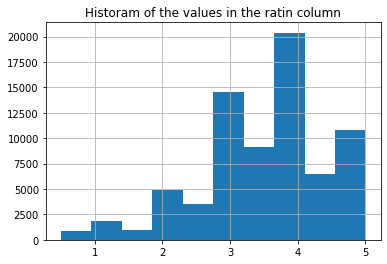

Average rating for each movie
                                               rating
title                                                
'Tis the Season for Love (2015)              1.500000
'burbs, The (1989)                           3.176471
(500) Days of Summer (2009)                  3.666667
00 Schneider - Jagd auf Nihil Baxter (1994)  4.500000
10 Cent Pistol (2015)                        1.250000
Sorted
                                                    rating
title                                                     
I'm the One That I Want (2000)                        5.00
Alien Contamination (1980)                            5.00
Galaxy of Terror (Quest) (1981)                       5.00
The Jinx: The Life and Deaths of Robert Durst (...    5.00
Sherlock - A Study in Pink (2010)                     4.75
CALCULATIN MOVIE FREQUENCY
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The

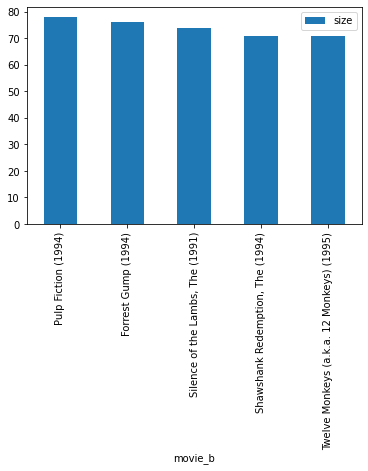

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# importing data
userrating_df = pd.read_csv("./user_ratings.csv")
# Inspect the listening_history_df DataFrame
print(userrating_df.head())

# finding the most popular items
print("finding the most popular items")
userrating_df['title'].value_counts()


# Calculate the number of unique values
print(userrating_df[['rating']].nunique())

# Display a histogram of the values in the Rating column
userrating_df['rating'].hist()
plt.title("Historam of the values in the ratin column")
# activate this to show the plot
plt.show()

# Finding the most liked items
print("Average rating for each movie")
avg_rating_df = userrating_df[["title", "rating"]].groupby(['title']).mean()
print(avg_rating_df.head())

# here we note that they are not sorted, we'll sort them then
sorted_avg_rating_df = avg_rating_df.sort_values(by='rating', ascending=False)
print("Sorted")
print(sorted_avg_rating_df.head())

# now we note that some movies have been sorted at first and they're not know,
# a movie with one good review has a solid chance to be sorted as one of the best movies

# calculating the movie frequency

print("CALCULATIN MOVIE FREQUENCY")
movie_frequency = userrating_df["title"].value_counts()
print(movie_frequency)

# we'll take the indexes of the frequently reviewed movies
print("FREQUENTLY REVIEWED MOVIES: ")
frequently_reviewed_movies = movie_frequency[movie_frequency > 100].index
print(frequently_reviewed_movies)

# taking a subset of the movies that are frequent, using the isin function
frequent_movies_df = userrating_df[userrating_df["title"].isin(frequently_reviewed_movies)]

# this subset will be used to show the highest books ratings on average
print("SUBSETTING...")
#frequent_movies_avgs = frequently_reviewed_movies[["title", "rating"]].groupby('title').mean()
#print(frequent_movies_avgs.sort_values(by="rating", ascending=False).head())


# Get the counts of occurrences of each movie title
movie_popularity = userrating_df["title"].value_counts()

# Inspect the most common values
print(movie_popularity.head().index)

# Find the mean of the ratings given to each title
average_rating_df = userrating_df[["title", "rating"]].groupby('title').mean()

# Order the entries by highest average rating to lowest
sorted_average_ratings = average_rating_df.sort_values(
    by="rating", ascending=False)

# Inspect the top movies
print(sorted_average_ratings.head())


#combining popularity and reviews 
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = userrating_df["title"].value_counts()
popular_movies = movie_popularity[movie_popularity > 50].index

print(popular_movies)

#filtering the original userratings_df by the popular movies list to creat a dataframe
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = userrating_df["title"].value_counts()
popular_movies = movie_popularity[movie_popularity > 50].index

# Use this popular_movies list to filter the original DataFrame
popular_movies_rankings = userrating_df[userrating_df["title"].isin(popular_movies)]

# Inspect the movies watched over 50 times
print(popular_movies_rankings)


#combining popularity and reviews 
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = userrating_df["title"].value_counts()
popular_movies = movie_popularity[movie_popularity > 50].index

# Use this popular_movies list to filter the original DataFrame
popular_movies_rankings =  userrating_df[userrating_df["title"].isin(popular_movies)]

# Find the average rating given to these frequently watched films
popular_movies_average_rankings = popular_movies_rankings[["title", "rating"]].groupby('title').head()
print(popular_movies_average_rankings.sort_values(by="rating", ascending=False).head())


#making sugestion by finding the similar
#i mean movies watched by the same person


#in this section  we'll study this part 
#for example we'll find the most common pairs and we'll sort them
print("FIDNING PAIRS")

from itertools import permutations

#defining the function that'll make the pairs for us, commenting the function after it 

def create_pairs(x):
    pairs = pd.DataFrame(list(permutations(x.values, 2 )), columns=['movie_a', 'movie_b'] )

    return pairs

"""
permutations(list, length_of_permutations) generates iterable object containing all permutations
list() converts this object to a usable list
pd.dataFrame() converts the list to a DataFrame containing the columns movie_a and movie_b
"""

#applying the function the data
movie_pairs = userrating_df.groupby("userId")['title'].apply(create_pairs)
#cleaning up the results
movie_pairs = movie_pairs.reset_index(drop = True)
print(movie_pairs.head())

# counting the pairings
pair_counts = movie_pairs.groupby(['movie_a', 'movie_b']).size()
pair_counts_df = pair_counts.to_frame(name= 'size').reset_index()
print("PAIR COUNTS DF")
print(pair_counts_df.head())

#loking up recomendataions
pair_counts_sorted = pair_counts_df.sort_values('size', ascending = False)

pair_counts_sorted[pair_counts_sorted['movie_a'] == 'Toy Story (1995)']



# Calculate how often each item in movies_a occurs with the items in movies_b
combination_counts = movie_pairs.groupby(['movie_a', 'movie_b']).size()

# Inspect the results
print(combination_counts.head())

# Calculate how often each item in movie_a occurs with the items in movie_b
combination_counts = movie_pairs.groupby(['movie_a', 'movie_b']).size()

# Convert the results to a DataFrame and reset the index
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
print(combination_counts_df.head())



#making the first movie recomendations 


# Sort the counts from highest to lowest
combination_counts_df.sort_values('size', ascending=False, inplace=True)

# Find the movies most frequently watched by people who watched Thor
thor_df = combination_counts_df[combination_counts_df['movie_a'] == 'Heat (1995)']

# Plot the results
print("BEST MATCHES", thor_df.head())
thor_df.head().plot.bar(x="movie_b")
plt.show()